In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

/opt/miniconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
casp = pd.read_csv("CASP.csv")
casp.head()

,RMSD,F1,F2,F3,F4,F5,F6,F7,F8,F9
0,17.284,13558.30,4305.35,0.31754,162.1730,1.872791e+06,215.3590,4287.87,102,27.0302
1,6.021,6191.96,1623.16,0.26213,53.3894,8.034467e+05,87.2024,3328.91,39,38.5468
2,9.275,7725.98,1726.28,0.22343,67.2887,1.075648e+06,81.7913,2981.04,29,38.8119
3,15.851,8424.58,2368.25,0.28111,67.8325,1.210472e+06,109.4390,3248.22,70,39.0651
4,7.962,7460.84,1736.94,0.23280,52.4123,1.021020e+06,94.5234,2814.42,41,39.9147


It is often a good idea to start gathering all information about the data we are trying to use. We will try to extract three layers of information from this dataset. Just to make it easier for us to do this, it is a good idea to wrap these commands into a function **get_dataset_details**. 

Here is a function that prints all the relevant details about the data.

* df.info() provides details about the non-null entries in each column of the dataframe
* df.describe() lists down all the relevant statistical features about the dataset like count, mean, standard deviation
* df.hist(), with "bins" argument, plots how each of the features are distrbuted

In [3]:
def get_dataset_details(df):
    print(df.info(),'\n')
    print(df.describe(),'\n')
    plt.show();

In [4]:
get_dataset_details(casp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45730 entries, 0 to 45729
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSD    45730 non-null  float64
 1   F1      45730 non-null  float64
 2   F2      45730 non-null  float64
 3   F3      45730 non-null  float64
 4   F4      45730 non-null  float64
 5   F5      45730 non-null  float64
 6   F6      45730 non-null  float64
 7   F7      45730 non-null  float64
 8   F8      45730 non-null  int64  
 9   F9      45730 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.5 MB
None 

               RMSD            F1            F2            F3            F4  \
count  45730.000000  45730.000000  45730.000000  45730.000000  45730.000000   
mean       7.748528   9871.596995   3017.367175      0.302392    103.492433   
std        6.118312   4058.138034   1464.324663      0.062886     55.424985   
min        0.000000   2392.050000    403.500000      0.092500     10.31010

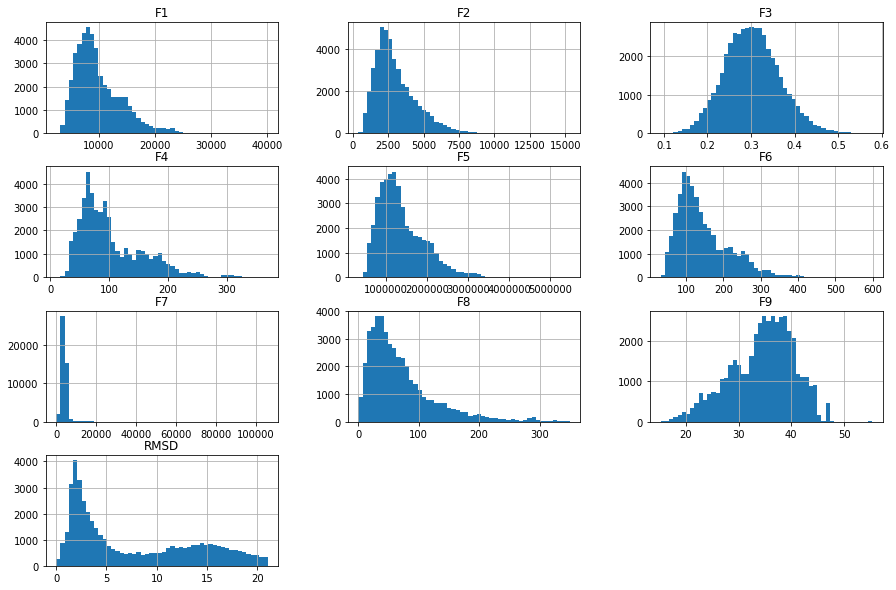

In [5]:
casp.hist(bins=50, figsize=(15,10));

Let us see if there is any missing data in the dataset

In [6]:
np.where(casp.values == np.nan)

(array([], dtype=int64), array([], dtype=int64))

In [7]:
def get_correlation(data):
    plt.figure(figsize=(15,10));
    pd.plotting.scatter_matrix(data, figsize=(20,10));

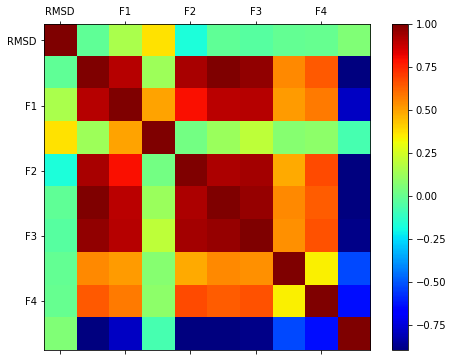

In [8]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cax = ax.matshow(casp.corr(), cmap = 'jet', interpolation='none')
fig.colorbar(cax)

ax.set_xticklabels(['']+list(casp));
ax.set_yticklabels(['']+list(casp));

<Figure size 1080x720 with 0 Axes>

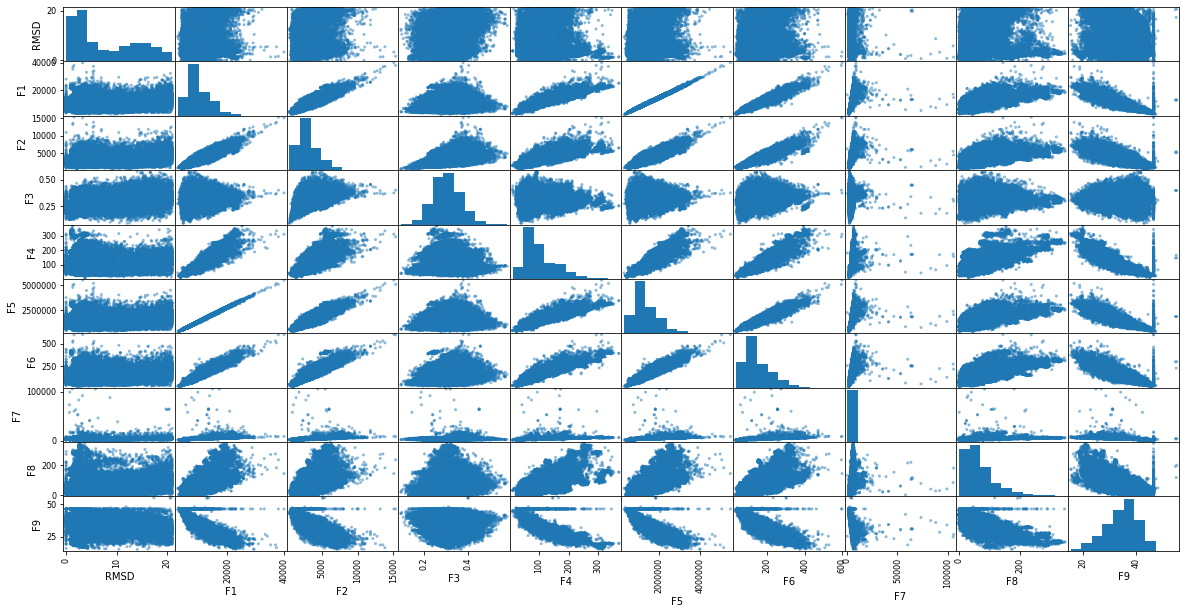

In [9]:
get_correlation(casp)

In [10]:
casp[casp['F7']<7500].corr()['RMSD'].sort_values(ascending=False)

RMSD    1.000000
F3      0.373967
F2      0.156547
F9      0.066031
F8     -0.001439
F5     -0.019722
F1     -0.020795
F7     -0.020812
F6     -0.042390
F4     -0.172639
Name: RMSD, dtype: float64

# Fit a linear regression model

Let us start with splitting the dataset into training set and test set. We will make use of Pipeline function from scikitlearn to be able to do scaling of the data and add polynomial features. 

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp.drop("RMSD", axis=1),casp["RMSD"], test_size=0.3, random_state=42)

In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler_pipeline = Pipeline([
    ("minmax_scaler", MinMaxScaler()),
    ("pca", PCA(n_components=0.99))
])
casp_scaled = scaler_pipeline.fit_transform(casp)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(casp_scaled[:,1:],casp_scaled[:,0], test_size=0.3, random_state=42)

In [57]:
X_train.shape

(32011, 5)

We ended up with 219 features altogether. How did this happen? 

The formula to calculate the total number of polynomial features after transormation is *C(n+r,r)* (Combination), where *n* is the number of features in the dataset and *r* is the degree of polynomial. In our case, this translates to $C(9+3,3) = 12!/ (12-3)! 3! = 220$. Since we did not opt for the bias term, we ended up with one less than 220, i.e., 219.

In [61]:
from sklearn.neural_network import MLPRegressor
import time
mlp_reg = MLPRegressor(random_state=48, max_iter=500, verbose=True, validation_fraction=0.5);

start_time = time.time()
mlp_reg.fit(X_train, y_train)
print('Time taken ' + str(time.time() - start_time))

Iteration 1, loss = 0.04678298
Iteration 2, loss = 0.03515376
Iteration 3, loss = 0.02649583
Iteration 4, loss = 0.02338627
Iteration 5, loss = 0.02220184
Iteration 6, loss = 0.02148651
Iteration 7, loss = 0.02079006
Iteration 8, loss = 0.02027154
Iteration 9, loss = 0.01971250
Iteration 10, loss = 0.01919477
Iteration 11, loss = 0.01896934
Iteration 12, loss = 0.01865888
Iteration 13, loss = 0.01845007
Iteration 14, loss = 0.01828346
Iteration 15, loss = 0.01813452
Iteration 16, loss = 0.01802799
Iteration 17, loss = 0.01787022
Iteration 18, loss = 0.01781312
Iteration 19, loss = 0.01760678
Iteration 20, loss = 0.01751269
Iteration 21, loss = 0.01742526
Iteration 22, loss = 0.01733256
Iteration 23, loss = 0.01718414
Iteration 24, loss = 0.01715901
Iteration 25, loss = 0.01708894
Iteration 26, loss = 0.01708591
Iteration 27, loss = 0.01697764
Iteration 28, loss = 0.01691852
Iteration 29, loss = 0.01682846
Iteration 30, loss = 0.01677755
Iteration 31, loss = 0.01673091
Iteration 32, los

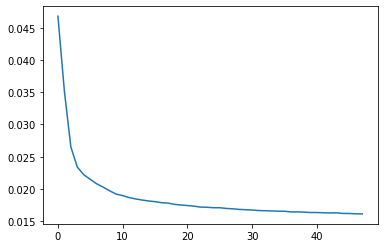

In [62]:
plt.plot(mlp_reg.loss_curve_)

In [63]:
def plot_results(X, y, lin_reg_model, name):
    plt.figure(figsize=(10,6))
    y_pred = lin_reg_model.predict(X)
    plt.scatter(y_pred,y, alpha=0.2)
    plt.plot([y_pred.min(),y_pred.max()],[y.min(),y.max()],'k')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("R2 Score = " +str(r2_score(lin_reg_model.predict(X), y)))
    plt.savefig(name+'.svg', format='svg')

In [64]:
from sklearn.metrics import mean_squared_error, r2_score
rmse_test = np.sqrt(mean_squared_error(lin_reg.predict(X_test),y_test))
rmse_train = np.sqrt(mean_squared_error(lin_reg.predict(X_train),y_train))
print("RMSE on train and test is ", rmse_train, rmse_test)

RMSE on train and test is  0.18205324317359853 0.18512613613380613


In [65]:
r2_model_score = r2_score(lin_reg.predict(X_test), y_test)

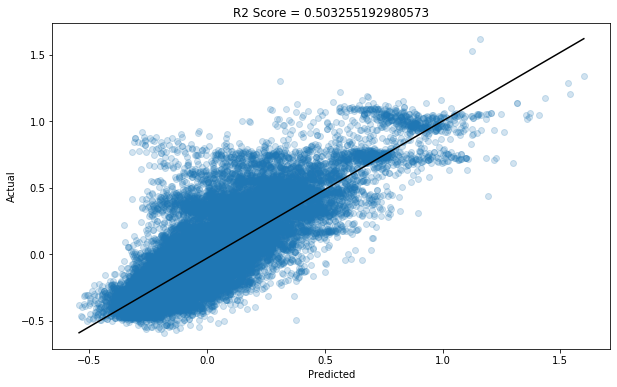

In [66]:
plot_results(X_train, y_train, lin_reg, "Without_PCA_Train")

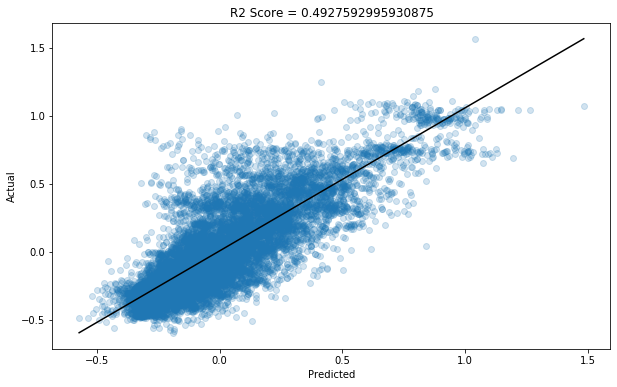

In [67]:
plot_results(X_test, y_test, lin_reg, "Without_PCA_Test")